Install this stuff first:

```
install.packages("scrm")
install.packages("https://github.com/YingZhou001/popdemog/raw/master/POPdemog_1.1.tar.gz", repos=NULL)
install.packages("tidyverse")
install.packages("glue")
```

In [1]:
library(scrm)
library(POPdemog)
library(tidyverse)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



### Set the coalescent parameters

In [2]:
scale_time <- function(t) { t / gen_time / (4 * Ne0) }
scale_Ne <- function(Ne) { Ne / Ne0 }
scale_migr <- function(m) { 4 * m * Ne0 }

In [3]:
# generation time
gen_time <- 25

# effective population size used for scaling below
Ne0 <- 10000

# how old are the sampled Neanderthal haplotypes?
T_nea_age <- 70000

# how many haplotypes to sample from each population?
n_afr <- 200
n_eur <- 100
n_nea <- 4
n_chimp <- 1

n_haplotypes <- 50000
hap_length <- 10001

# split between Homo and Chimp
T_chimp_split <- 6000000
# split between MH and Neanderthals
T_nea_mh_split <- 600000
# African/non-African split and bottleneck
T_afr_nonafr_split <- 70000

# Ne during the Out of Africa bottleneck
Ne_bottleneck <- 2000

# size of the Neanderthal population
Ne_nea <- 1000

# size of the ancestral population
Ne_anc <- 10000

# EUR <-> AFR migration rates
m_afr_bottle <- 15e-5
m_afr_eur <- 1e-4 # 2.5e-5
T_m_afr_eur <- 15000

# Neanderthal introgression parameters
T_nea_admix_start <- 55000
T_nea_admix_end <- T_nea_admix_start - 1000
m_nea_admix <- 0.0005

# mutation rate per site per generation
mut_rate <- 2.5e-8
# probability of cross-over between adjacent bases per generation 
recomb_rate <- 1e-8

# population scaled mutation and recombination rates
theta <- 4 * Ne0 * mut_rate * hap_length
rho <- 4 * Ne0 * recomb_rate * hap_length

In [4]:
n_haplotypes * hap_length / 3e6

[1] 166.6833

Generate the command line options for time-sampling (4 Neanderthal haplotypes at 70ky ago and a single EMH haplotype at different time points specified from the Ice Age paper):

In [5]:
emh_ages <- read_delim("../data/emh_ages.txt", col_types="ci", col_names=c("name", "age"), delim=" ") %>%
    filter(name != "Oase1") %>%
    mutate(name=paste0("emh_", 1:nrow(.)))

In [6]:
ages <- bind_rows(emh_ages, tibble(name=paste0("eur_", 1:n_eur), age=0)) # add the "fake" present-day Europeans

In [7]:
eI <- c(
  glue("-eI {scale_time(T_nea_age)}             0        0       {n_nea}    0"), # Neanderthals
  glue("-eI {map_dbl(emh_ages$age, scale_time)} 0        1       0          0"), # EMHs
  glue("-eI 0                                   {n_afr}  0       0          0"), # present-day Africans
  glue("-eI 0                                   0        {n_eur} 0          0"), # present-day Europeans
  glue("-eI 0                                   0        0       0  {n_chimp}")  # present-day chimp
) %>%
  paste(collapse=" ")

### Compose the `scrm` command line string

In [8]:
scrm_cmd <- glue(

"{n_nea + n_afr + n_eur + nrow(emh_ages) + n_chimp} {n_haplotypes} \\
-I 4 0 0 0 0 \\
-r {rho} {hap_length} \\
-t {theta} \\
-n 3 {scale_Ne(Ne_nea)} \\

-em {scale_time(T_nea_admix_end)} 2 3 {scale_migr(m_nea_admix)} \\
-em {scale_time(T_nea_admix_start)} 2 3 0 \\
-en {scale_time(T_nea_admix_start)} 2 {scale_Ne(Ne_bottleneck)} \\

-em 0 1 2 {scale_migr(m_afr_eur)} \\
-em {scale_time(T_m_afr_eur)} 1 2 0 \\

-ej {scale_time(T_afr_nonafr_split)} 2 1 \\
-ej {scale_time(T_nea_mh_split)} 3 1 \\
-ej {scale_time(T_chimp_split)} 4 1 \\

{eI}"

) %>% str_replace_all("\n", " ") %>% str_replace_all("  +", " ")

### Check that the demographic model looks reasonable

There are  7 time events for  4  populations
read N and g, done!
read m, done!
read pos and update, done!
demographic initiation, done!
plot initiation, done!


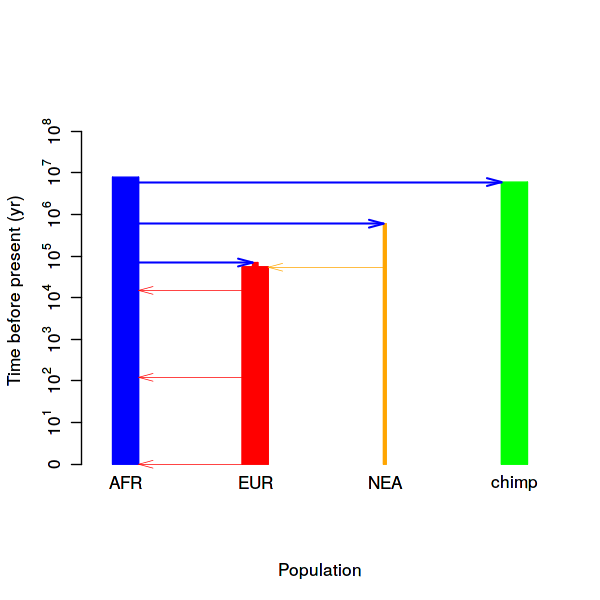

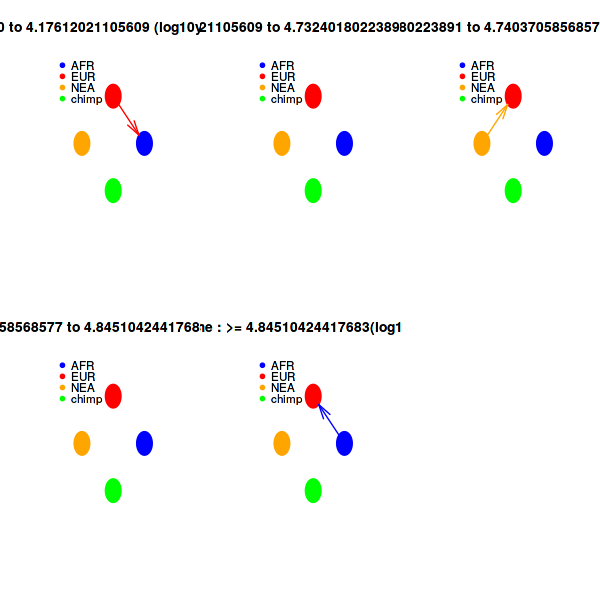

In [9]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=100)

PlotMS(scrm_cmd, type="scrm",
       pops=c("AFR", "EUR", "NEA", "chimp"),
       col.pop=c("blue", "red", "orange", "green"),
       time.scale="log10year", N4=4*Ne0,
       demo.out=TRUE) -> plot_out
PlotMMig(demograph_out=plot_out$demograph_out, mig_par=plot_out$mig_par)

### Run the simulation and extract the matrix with simulated haplotypes

In [10]:
paste("scrm", scrm_cmd)

[1] "scrm 355 50000 -I 4 0 0 0 0 -r 4.0004 10001 -t 10.001 -n 3 0.1 -em 0.054 2 3 20 -em 0.055 2 3 0 -en 0.055 2 0.2 -em 0 1 2 4 -em 0.015 1 2 0 -ej 0.07 2 1 -ej 0.6 3 1 -ej 6 4 1 -eI 0.07 0 0 4 0 -eI 0.04502 0 1 0 0 -eI 0.03747 0 1 0 0 -eI 0.034795 0 1 0 0 -eI 0.0333 0 1 0 0 -eI 0.032895 0 1 0 0 -eI 0.032435 0 1 0 0 -eI 0.032415 0 1 0 0 -eI 0.03097 0 1 0 0 -eI 0.03087 0 1 0 0 -eI 0.03087 0 1 0 0 -eI 0.03087 0 1 0 0 -eI 0.03026 0 1 0 0 -eI 0.03001 0 1 0 0 -eI 0.03001 0 1 0 0 -eI 0.028975 0 1 0 0 -eI 0.027975 0 1 0 0 -eI 0.02775 0 1 0 0 -eI 0.02762 0 1 0 0 -eI 0.027515 0 1 0 0 -eI 0.02632 0 1 0 0 -eI 0.024305 0 1 0 0 -eI 0.01872 0 1 0 0 -eI 0.01671 0 1 0 0 -eI 0.01671 0 1 0 0 -eI 0.015465 0 1 0 0 -eI 0.01513 0 1 0 0 -eI 0.015005 0 1 0 0 -eI 0.01478 0 1 0 0 -eI 0.01467 0 1 0 0 -eI 0.014615 0 1 0 0 -eI 0.01398 0 1 0 0 -eI 0.013665 0 1 0 0 -eI 0.013255 0 1 0 0 -eI 0.01296 0 1 0 0 -eI 0.011725 0 1 0 0 -eI 0.010855 0 1 0 0 -eI 0.010085 0 1 0 0 -eI 0.0099 0 1 0 0 -eI 0.00972 0 1 0 0 -eI 0.0092 0 1 0 0 -eI 0.008375 0 1 0 0 -eI 0.008265 0 1 0 0 -eI 0.008245 0 1 0 0 -eI 0.008205 0 1 0 0 -eI 0.00805 0 1 0 0 -eI 0.007815 0 1 0 0 -eI 0.00766 0 1 0 0 -eI 0.007625 0 1 0 0 -eI 0.007245 0 1 0 0 -eI 0.00714 0 1 0 0 -eI 0 200 0 0 0 -eI 0 0 100 0 0 -eI 0 0 0 0 1"

In [13]:
sim_res <- scrm(scrm_cmd)

In [14]:
# generate column names for the output df
col_names <- c(paste0("nea_", 1:n_nea),
               emh_ages$name,
               paste0("afr_", 1:n_afr),
               paste0("eur_", 1:n_eur),
               "chimp")

In [15]:
# extract matrices with simulated haplotypes and set the column names
all_sites <- map(sim_res$seg_sites, ~ .x %>% t %>% as_tibble %>% setNames(col_names)) %>% bind_rows

In [18]:
nrow(all_sites)

[1] 11034347

In [17]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12120277,647.3,34818565,1859.6,43523207,2324.4
Vcells,7899123611,60265.6,18086077433,137985.9,11834480166,90290.0


In [19]:
saveRDS(all_sites, "../data/RData/sites.rds")

## Design the archaic admixture array
Keep only those sites that are nearly fixed in Africans, and fixed for a different allele in the Neanderthals (ignore the derived/ancestral state).

**To make testing easier, I'm requiring the African allele to be fixed! This can be changed later.**

In [26]:
# the lowest frequency of an allele allowed in the African population
afr_cutoff <- 1.0

In [27]:
calc_freq <- function(df, pop) {
    df[str_detect(col_names, pop)] %>% rowSums / sum(str_detect(col_names, pop))
}

In [28]:
afr_freq <- calc_freq(all_sites, "afr")
nea_freq <- calc_freq(all_sites, "nea")

In [29]:
admix_array <- filter(all_sites,
                     (afr_freq == 0 | afr_freq >= afr_cutoff) &
                     (nea_freq == 0 | nea_freq == 1) &
                     (abs(afr_freq - nea_freq) > 0.5))

In [30]:
nrow(admix_array)

[1] 480219

What are the observed site patterns in Africans and Neanderthals? There should be only two:

In [31]:
distinct(select(admix_array, starts_with("afr"), starts_with("nea"))) %>% nrow

[1] 2

## Design the "Big Yoruba" array

Select 4 African haplotypes and 2 Neanderthal haplotypes and keep sites that are heterozygous in either of them (Big Yoruba array was designed on hets in 2 YRI males and hets in Altai).

In [32]:
bigyri_array <- filter(all_sites, (nea_1 != nea_2) | (afr_1 != afr_2) | (afr_3 != afr_4))

In [33]:
nrow(bigyri_array)

[1] 898775

### Detect Neanderthal introgressed alleles in all simulated haplotypes

Detect all Neanderthal alleles in the non-African population (TRUE/FALSE at each site converted to integers - 1 is Nea-like allele, 0 is an African-like MH allele):

In [34]:
nea_states <- map_df(admix_array, ~ as.integer(. == admix_array$nea_1))

What are the leves of Nea. ancestry in non-African haplotypes?

In [35]:
nea_ancestry <- function(df, pop) {
    select(df, starts_with(pop)) %>% summarise_all(mean)
}

### Check the SFS of introgressed alleles in present-day Europeans

### Plot the simulated Nea. ancestry over time

In [36]:
f4 <- function(df, w, x, y, z) {
    sum((df[[w]] - df[[x]]) * (df[[y]] - df[[z]]))
}

f4_ratio <- function(df, x, a, b, c, o) {
    f4(df, a, o, x, c) / f4(df, a, o, b, c)
}

Nea. ancestry using "direct" calculation on admixture array sites:

In [37]:
admix_nea <- bind_cols(nea_ancestry(nea_states, "emh"), nea_ancestry(nea_states, "eur")) %>%
    gather(name, nea) %>% mutate(method="admix_array_direct")

In [38]:
bigyri_nea <- tibble(name=c(emh_ages$name, paste0("eur_", 1:n_eur))) %>%
    mutate(nea=map_dbl(name, ~ f4_ratio(bigyri_array, ., "nea_3", "nea_4", "afr_5", "chimp")),
           method="bigYRI_f4")

In [39]:
admix_neaf4 <- tibble(name=c(emh_ages$name, paste0("eur_", 1:n_eur))) %>%
    mutate(nea=map_dbl(name, ~ f4_ratio(admix_array, ., "nea_3", "nea_4", "afr_5", "chimp")),
           method="admix_array_f4")

In [40]:
nea_est <- bind_rows(admix_nea, admix_neaf4, bigyri_nea) %>% inner_join(ages)

Joining, by = "name"


In [48]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=200)

Warning message:
“Removed 12 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 12 rows containing missing values (geom_point).”

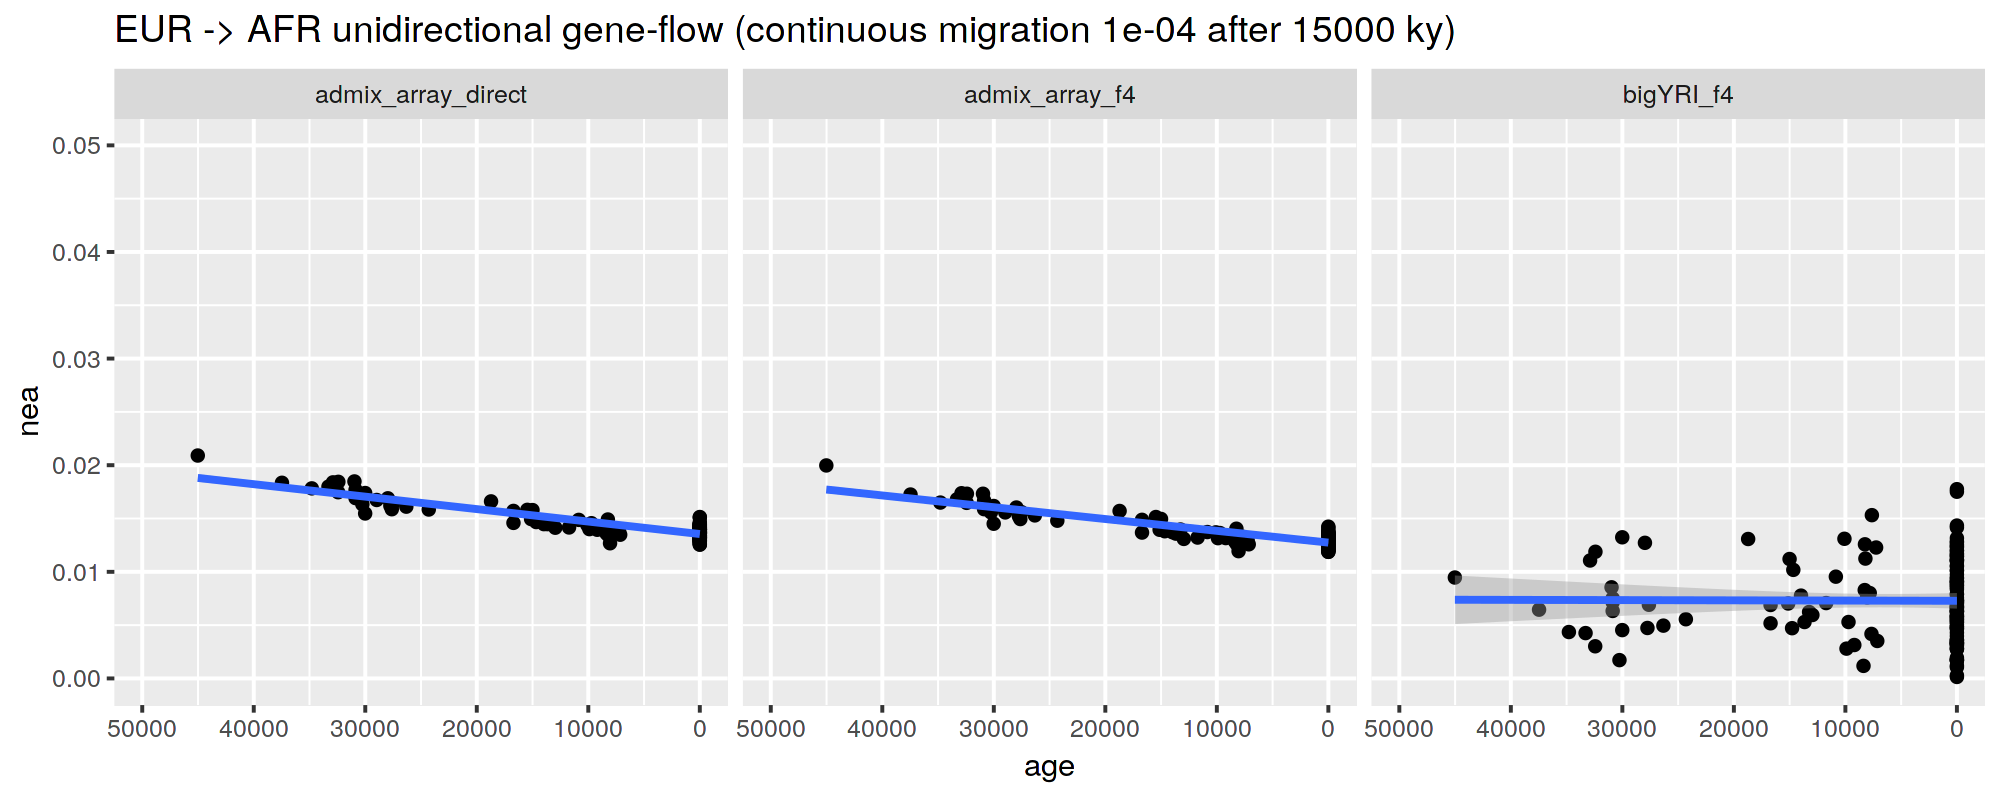

In [49]:
ggplot(nea_est, aes(age, nea)) +
ggtitle(paste("EUR -> AFR unidirectional gene-flow (continuous migration", m_afr_eur, "after", T_m_afr_eur, "ky)")) +
geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm") +
facet_grid(. ~ method)

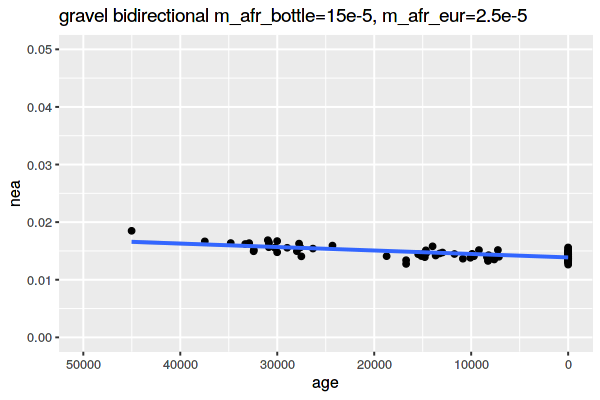

In [28]:
ggplot(sim_nea, aes(age, nea)) + ggtitle("gravel bidirectional m_afr_bottle=15e-5, m_afr_eur=2.5e-5") + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")

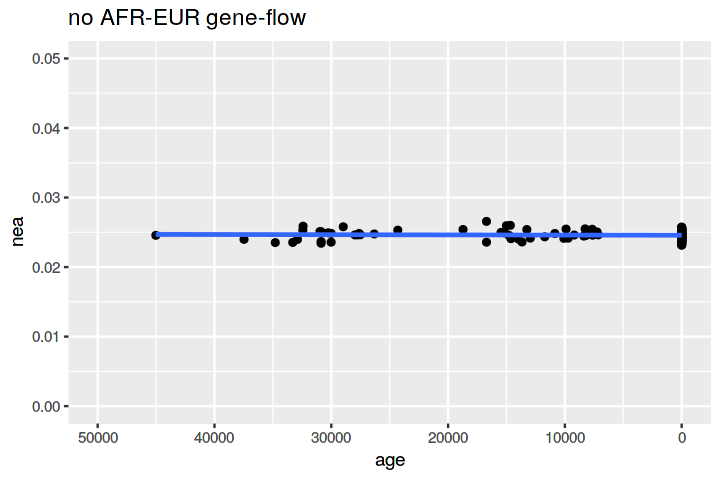

In [27]:
ggplot(sim_nea, aes(age, nea)) + ggtitle("no AFR-EUR gene-flow") + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")

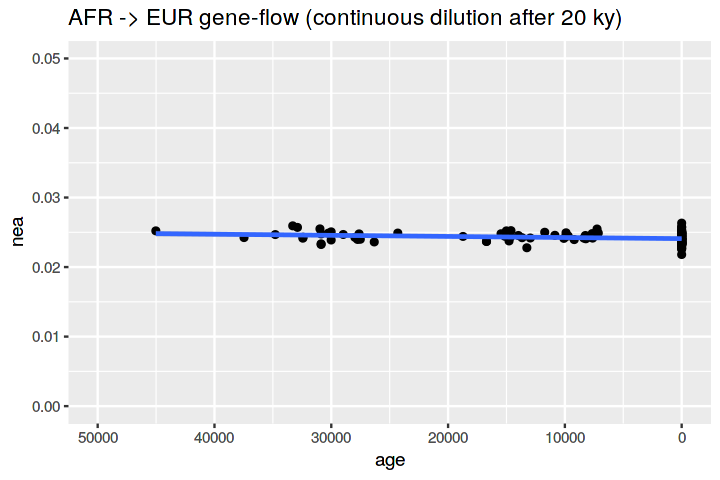

In [25]:
ggplot(sim_nea, aes(age, nea)) + ggtitle("AFR -> EUR gene-flow (continuous dilution after 20 ky)") + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")

lower migration rate

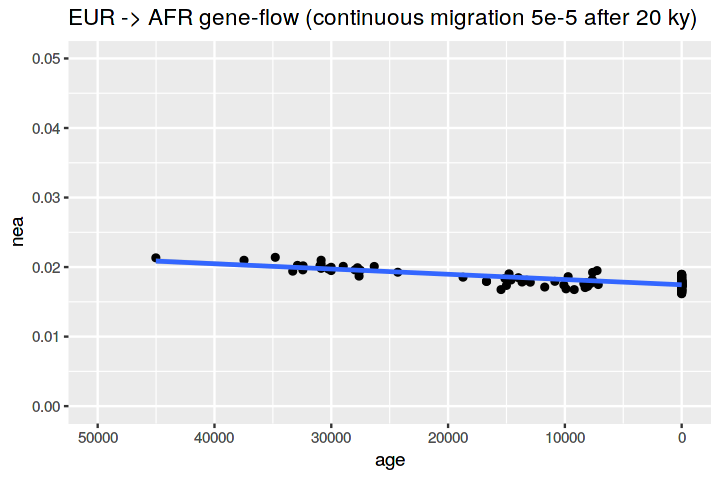

In [25]:
ggplot(sim_nea, aes(age, nea)) + ggtitle("EUR -> AFR gene-flow (continuous migration 5e-5 after 20 ky)") + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")

higher migration rate

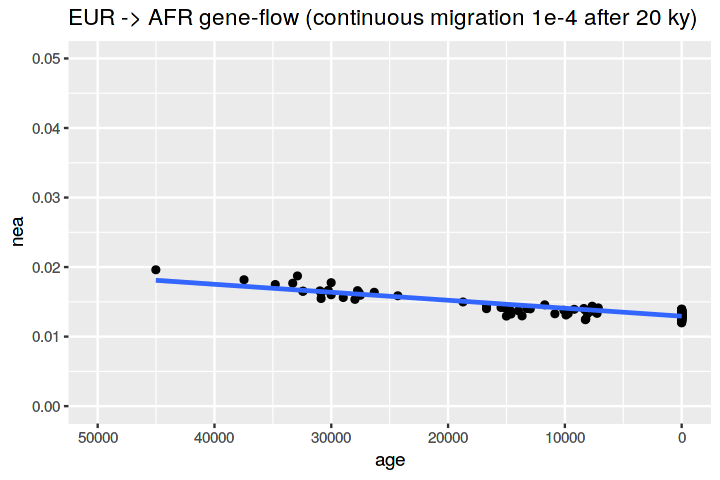

In [24]:
ggplot(sim_nea, aes(age, nea)) + ggtitle("EUR -> AFR gene-flow (continuous migration 1e-4 after 20 ky)") + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")

higher migration rate + bidirectional geneflow

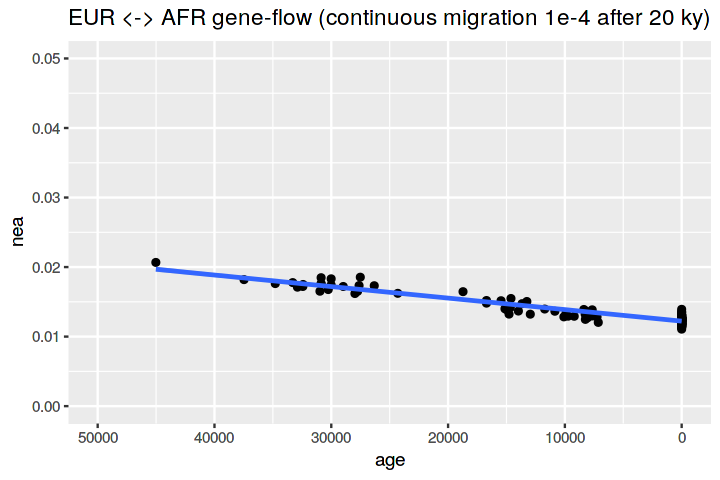

In [24]:
ggplot(sim_nea, aes(age, nea)) + ggtitle("EUR <-> AFR gene-flow (continuous migration 1e-4 after 20 ky)") + geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm")